# [Baseball Databank](http://www.seanlahman.com/baseball-archive/statistics/)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from typing import Tuple, Callable

In [4]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [5]:
# show matplotlib plots in notebook
%matplotlib inline

In [6]:
# set matplotlib style/theme
plt.style.use("fivethirtyeight")

In [7]:
# plotly defaults
pio.renderers.default = "notebook"
pio.templates.default = "seaborn"

In [8]:
from tabulate import tabulate
from IPython.core.display import display, Markdown, HTML

def markdown(s: str):
    display(Markdown(s))
    
def html(s: str):
    display(HTML(s))

In [9]:
# path to data files
datapath = Path("../baseballdatabank/core")

___________________
## Pitching info

In [11]:
pitching = pd.read_csv(datapath/"pitching.csv")
pitching.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48399 entries, 0 to 48398
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   playerID  48399 non-null  object 
 1   yearID    48399 non-null  int64  
 2   stint     48399 non-null  int64  
 3   teamID    48399 non-null  object 
 4   lgID      48267 non-null  object 
 5   W         48399 non-null  int64  
 6   L         48399 non-null  int64  
 7   G         48399 non-null  int64  
 8   GS        48399 non-null  int64  
 9   CG        48399 non-null  int64  
 10  SHO       48399 non-null  int64  
 11  SV        48399 non-null  int64  
 12  IPouts    48399 non-null  int64  
 13  H         48399 non-null  int64  
 14  ER        48399 non-null  int64  
 15  HR        48399 non-null  int64  
 16  BB        48399 non-null  int64  
 17  SO        48399 non-null  int64  
 18  BAOpp     43958 non-null  float64
 19  ERA       48305 non-null  float64
 20  IBB       33821 non-null  fl

## People info

In [13]:
people = pd.read_csv(datapath/"people.csv")
for col in "debut", "finalGame":
    people[col] = pd.to_datetime(people[col])

In [14]:
# slimmed people dataframe with player ID, full name, first and final games as datetimes
people_slim = pd.concat([people["playerID"], 
                         people[["nameFirst", "nameLast"]].fillna("").agg(" ".join, axis=1).rename("fullName"), 
                         people["debut"].apply(lambda dt: dt.year).fillna(0).astype(np.int), 
                         people["finalGame"].apply(lambda dt: dt.year).fillna(0).astype(np.int)], 
                        axis=1)
people_slim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20093 entries, 0 to 20092
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   playerID   20093 non-null  object
 1   fullName   20093 non-null  object
 2   debut      20093 non-null  int64 
 3   finalGame  20093 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 628.0+ KB


_____________________
### Convenience functions

In [25]:
# All-time <stat> leaders (using sum aggregation)
def leaders(df_stat: pd.DataFrame, df_people: pd.DataFrame, stat: str, count: int=10):
    _leaders = (df_stat.pivot_table(values=stat, columns="yearID", index="playerID", fill_value=0, aggfunc=np.sum)
                  .astype(np.int)
                  .sum(axis=1)
                  .sort_values(ascending=False)
                  .rename(stat)
                  .head(count))
    return pd.merge(df_people, _leaders, on="playerID").sort_values(stat, ascending=False)

In [80]:
# All-time <stat> leaders (using mean aggregation)
def leaders_mean(df_stat: pd.DataFrame, df_people: pd.DataFrame, stat: str, count: int=10, ascending=False):
    _leaders = (df_stat.pivot_table(values=stat, columns="yearID", index="playerID", aggfunc=np.mean)
                  .mean(axis=1)
                  .sort_values(ascending=ascending)
                  .rename(stat)
                  .head(count))
    return pd.merge(df_people, _leaders, on="playerID").sort_values(stat, ascending=False)

In [27]:
# Bar-plot leaders
def leaders_barplot_sns(df: pd.DataFrame, stat: str, figsize: Tuple[int, int]=(7,6), stat_label: str=None):
    if stat_label is None:
        stat_label = stat
    plt.figure(figsize=figsize)
    bp = sns.barplot(x="fullName", y=stat, data=df, palette="crest_r")
    bp.set(xlabel=None, ylabel=f"Career {stat_label}", title=f"All-time {stat_label} Leaders")
    bp.set_xticklabels(bp.get_xticklabels(), rotation=60)
    plt.tight_layout()
    return bp

**NOTE** the bizarre name difference betwen setting ```custom_data``` and using ```customdata``` in plotly.express

In [28]:
# plotly plot
def leaders_barplot_plotly(df: pd.DataFrame, stat:str, stat_label: str=None):
    if stat_label is None:
        stat_label = stat
    bp = px.bar(df, 
                x="fullName", 
                y=stat, 
                title=f"All-time {stat_label} Leaders",
                custom_data=["debut", "finalGame"])
    bp.update_traces(hovertemplate="<b>%{x}</b>: %{y} (%{customdata[0]}-%{customdata[1]})")
    bp.update_xaxes(title=None)
    bp.update_yaxes(title=f"Career {stat_label}")
    return bp

_____________________________________
# Players: All-time Pitching Leaders

## Strikeouts

In [32]:
so_leaders = leaders(pitching, people_slim, "SO")
so_leaders

,playerID,fullName,debut,finalGame,SO
7,ryanno01,Nolan Ryan,1966,1993,5714
3,johnsra05,Randy Johnson,1988,2009,4875
2,clemero02,Roger Clemens,1984,2007,4672
1,carltst01,Steve Carlton,1965,1988,4136
0,blylebe01,Bert Blyleven,1970,1992,3701
8,seaveto01,Tom Seaver,1967,1986,3640
9,suttodo01,Don Sutton,1966,1988,3574
6,perryga01,Gaylord Perry,1962,1983,3534
4,johnswa01,Walter Johnson,1907,1927,3509
5,maddugr01,Greg Maddux,1986,2008,3371


<AxesSubplot:title={'center':'All-time Strikeouts Leaders'}, ylabel='Career Strikeouts'>

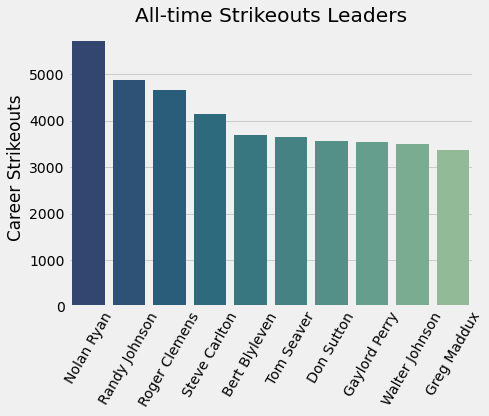

In [103]:
leaders_barplot_sns(so_leaders, "SO", stat_label="Strikeouts")

In [104]:
leaders_barplot_plotly(so_leaders, "SO", stat_label="Strikeouts")

## Wins

In [41]:
w_leaders = leaders(pitching, people_slim, "W")
w_leaders

,playerID,fullName,debut,finalGame,W
9,youngcy01,Cy Young,1890,1911,511
3,johnswa01,Walter Johnson,1907,1927,417
0,alexape01,Pete Alexander,1911,1930,373
6,mathech01,Christy Mathewson,1900,1916,373
2,galvipu01,Pud Galvin,1875,1892,365
8,spahnwa01,Warren Spahn,1942,1965,363
7,nichoki01,Kid Nichols,1890,1906,362
5,maddugr01,Greg Maddux,1986,2008,355
1,clemero02,Roger Clemens,1984,2007,354
4,keefeti01,Tim Keefe,1880,1893,342


<AxesSubplot:title={'center':'All-time Wins Leaders'}, ylabel='Career Wins'>

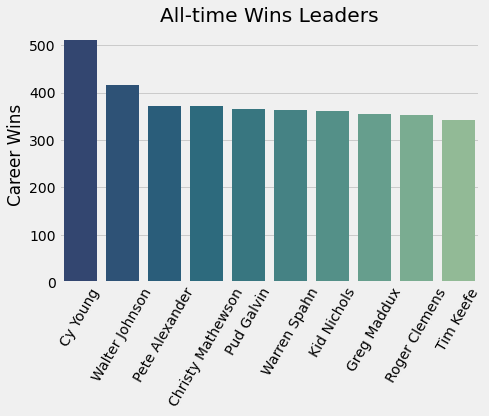

In [101]:
leaders_barplot_sns(w_leaders, "W", stat_label="Wins")

In [102]:
leaders_barplot_plotly(w_leaders, "W", stat_label="Wins")

## Net Wins (Wins - Losses)

In [46]:
pitching["Net W"] = pitching["W"] - pitching["L"]

In [48]:
netw_leaders = leaders(pitching, people_slim, "Net W")
netw_leaders

,playerID,fullName,debut,finalGame,Net W
9,youngcy01,Cy Young,1890,1911,196
8,spaldal01,Al Spalding,1871,1878,187
6,mathech01,Christy Mathewson,1900,1916,185
2,clemero02,Roger Clemens,1984,2007,170
0,alexape01,Pete Alexander,1911,1930,165
3,grovele01,Lefty Grove,1925,1941,159
7,nichoki01,Kid Nichols,1890,1906,154
1,clarkjo01,John Clarkson,1882,1894,150
5,johnswa01,Walter Johnson,1907,1927,138
4,johnsra05,Randy Johnson,1988,2009,137


<AxesSubplot:title={'center':'All-time Net Wins Leaders'}, ylabel='Career Net Wins'>

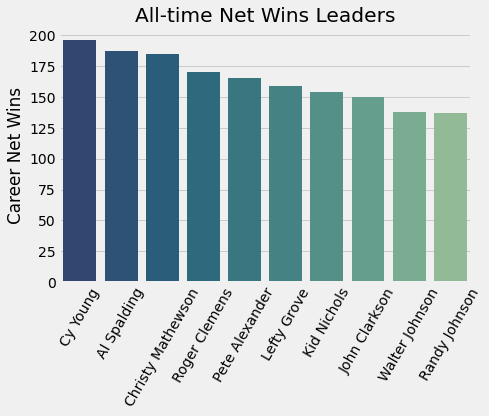

In [49]:
leaders_barplot_sns(netw_leaders, "Net W", stat_label="Net Wins")

In [64]:
leaders_barplot_plotly(netw_leaders, "Net W", stat_label="Net Wins")

## Saves

In [54]:
sv_leaders = leaders(pitching, people_slim, "SV")
sv_leaders

,playerID,fullName,debut,finalGame,SV
6,riverma01,Mariano Rivera,1995,2013,652
2,hoffmtr01,Trevor Hoffman,1993,2010,601
8,smithle02,Lee Smith,1980,1997,478
7,rodrifr03,Francisco Rodriguez,2002,2017,437
1,francjo01,John Franco,1984,2005,424
9,wagnebi02,Billy Wagner,1995,2010,422
0,eckerde01,Dennis Eckersley,1975,1998,390
3,nathajo01,Joe Nathan,1999,2016,377
4,papeljo01,Jonathan Papelbon,2005,2016,368
5,reardje01,Jeff Reardon,1979,1994,367


<AxesSubplot:title={'center':'All-time Saves Leaders'}, ylabel='Career Saves'>

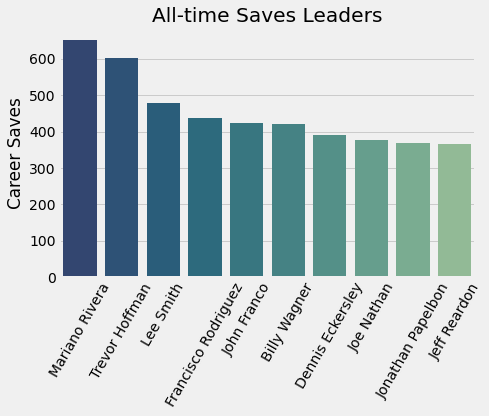

In [56]:
leaders_barplot_sns(sv_leaders, "SV", stat_label="Saves")

In [57]:
leaders_barplot_plotly(sv_leaders, "SV", stat_label="Saves")

## Games Pitched

In [50]:
g_leaders = leaders(pitching, people_slim, "G")
g_leaders

,playerID,fullName,debut,finalGame,G
3,oroscje01,Jesse Orosco,1979,2003,1252
6,stantmi02,Mike Stanton,1989,2007,1178
1,francjo01,John Franco,1984,2005,1119
5,riverma01,Mariano Rivera,1995,2013,1115
0,eckerde01,Dennis Eckersley,1975,1998,1071
9,wilheho01,Hoyt Wilhelm,1952,1972,1070
4,plesada01,Dan Plesac,1986,2003,1064
8,timlimi01,Mike Timlin,1991,2008,1058
7,tekulke01,Kent Tekulve,1974,1989,1050
2,hawkila01,LaTroy Hawkins,1995,2015,1042


<AxesSubplot:title={'center':'All-time Games Pitched Leaders'}, ylabel='Career Games Pitched'>

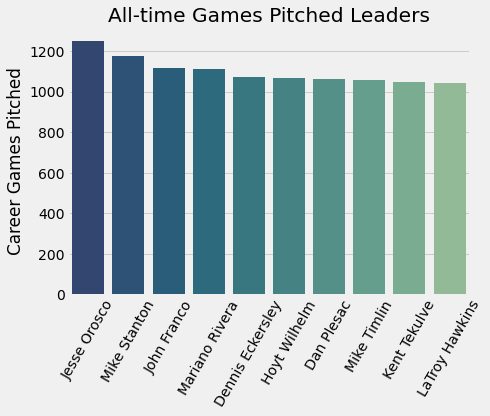

In [52]:
leaders_barplot_sns(g_leaders, "G", stat_label="Games Pitched")

In [53]:
leaders_barplot_plotly(g_leaders, "G", stat_label="Games Pitched")

## Shutouts

In [58]:
sho_leaders = leaders(pitching, people_slim, "SHO")
sho_leaders

,playerID,fullName,debut,finalGame,SHO
2,johnswa01,Walter Johnson,1907,1927,110
0,alexape01,Pete Alexander,1911,1930,90
3,mathech01,Christy Mathewson,1900,1916,79
9,youngcy01,Cy Young,1890,1911,76
4,planked01,Eddie Plank,1901,1917,69
7,spahnwa01,Warren Spahn,1942,1965,63
5,ryanno01,Nolan Ryan,1966,1993,61
6,seaveto01,Tom Seaver,1967,1986,61
1,blylebe01,Bert Blyleven,1970,1992,60
8,suttodo01,Don Sutton,1966,1988,58


<AxesSubplot:title={'center':'All-time Shutout Leaders'}, ylabel='Career Shutout'>

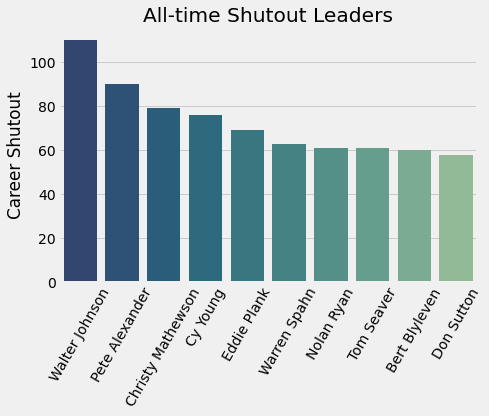

In [59]:
leaders_barplot_sns(sho_leaders, "SHO", stat_label="Shutout")

In [60]:
leaders_barplot_plotly(sho_leaders, "SHO", stat_label="Shutout")

## Complete Games

In [65]:
cg_leaders = leaders(pitching, people_slim, "CG")
cg_leaders

,playerID,fullName,debut,finalGame,CG
9,youngcy01,Cy Young,1890,1911,749
1,galvipu01,Pud Galvin,1875,1892,646
3,keefeti01,Tim Keefe,1880,1893,554
6,nichoki01,Kid Nichols,1890,1906,532
2,johnswa01,Walter Johnson,1907,1927,531
4,mathebo01,Bobby Mathews,1871,1887,525
8,welchmi01,Mickey Welch,1880,1892,525
7,radboch01,Old Hoss Radbourn,1880,1891,488
0,clarkjo01,John Clarkson,1882,1894,485
5,mullato01,Tony Mullane,1881,1894,468


<AxesSubplot:title={'center':'All-time Complete Games Leaders'}, ylabel='Career Complete Games'>

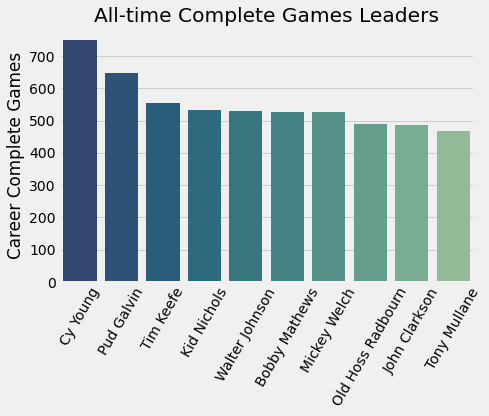

In [66]:
leaders_barplot_sns(cg_leaders, "CG", stat_label="Complete Games")

In [68]:
leaders_barplot_plotly(cg_leaders, "CG", stat_label="Complete Games")

## Bad Pitches (Wild Pitches + Hit Batters)

In [70]:
pitching["bad pitch"] = pitching["WP"] + pitching["HBP"]

In [73]:
bad_pitch_leaders = leaders(pitching, people_slim, "bad pitch")
bad_pitch_leaders

,playerID,fullName,debut,finalGame,bad pitch
9,weyhigu01,Gus Weyhing,1887,1901,517
5,mullato01,Tony Mullane,1881,1894,465
7,ryanno01,Nolan Ryan,1966,1993,435
1,frasech01,Chick Fraser,1896,1909,365
3,johnswa01,Walter Johnson,1907,1927,358
8,terryad01,Adonis Terry,1884,1897,354
2,houghch01,Charlie Hough,1970,1994,353
6,niekrph01,Phil Niekro,1964,1987,349
0,baldwma01,Mark Baldwin,1887,1893,344
4,kilroma01,Matt Kilroy,1886,1898,334


<AxesSubplot:title={'center':'All-time Bad Pitch Leaders'}, ylabel='Career Bad Pitch'>

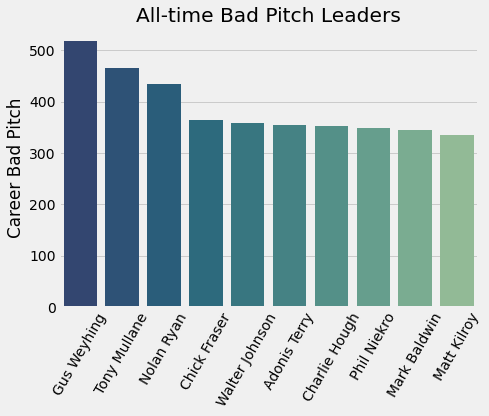

In [78]:
leaders_barplot_sns(bad_pitch_leaders, "bad pitch", stat_label="Bad Pitch")

In [77]:
leaders_barplot_plotly(bad_pitch_leaders, "bad pitch", stat_label="Bad Pitch")

## Career-average ERA (with minimum N outs pitched)

In [112]:
# check distribution of outs pitched for filtering
ipouts = pitching.pivot_table(columns="yearID", index="playerID", values="IPouts").sum(axis=1).rename("IPouts")
ipouts.describe()

count     9993.000000
mean      1137.186332
std       2005.907781
min          0.000000
25%         47.000000
50%        261.000000
75%       1290.000000
max      21878.500000
Name: IPouts, dtype: float64

In [129]:
# filter to only IPouts > median
era_leaders = leaders_mean(pitching[pitching["IPouts"] > 261], 
                           pd.merge(people_slim, 
                                    ipouts, 
                                    on="playerID"), 
                           "ERA", 
                           ascending=True)
era_leaders

,playerID,fullName,debut,finalGame,IPouts,ERA
5,moylape01,Peter Moylan,2006,2018,1256.000000,1.800
7,pfiesja01,Jack Pfiester,1903,1911,3202.000000,1.776
0,beckro01,Rod Beck,1991,2004,2238.000000,1.760
8,scurrro01,Rod Scurry,1980,1988,1291.500000,1.740
1,beenefr01,Fred Beene,1968,1975,739.500000,1.680
3,krohru01,Rube Kroh,1906,1912,649.000000,1.650
4,mccarto02,Tom McCarthy,1908,1909,242.666667,1.630
9,wittge01,Red Witt,1957,1962,649.000000,1.610
6,nenro01,Robb Nen,1993,2002,2061.000000,1.520
2,betande01,Dellin Betances,2011,2020,1180.000000,1.400


<AxesSubplot:title={'center':'All-time ERA Leaders'}, ylabel='Career ERA'>

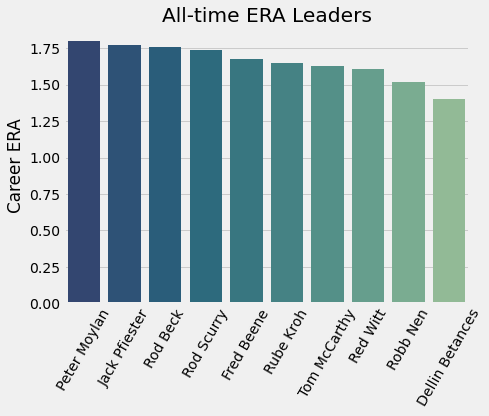

In [144]:
leaders_barplot_sns(era_leaders, "ERA", stat_label="ERA")

In [138]:
bp = px.bar(era_leaders, 
            x="fullName", 
            y="ERA", 
            title=f"Lowest average ERA",
            custom_data=["debut", "finalGame", "IPouts"])
bp.update_traces(hovertemplate="<b>%{x}</b>: %{y} (%{customdata[2]:.1f} outs, %{customdata[0]}-%{customdata[1]})")
bp.update_xaxes(title=None)
bp.update_yaxes(title=f"ERA", tickformat=".2f")

## Opponents Batting Average

In [136]:
# filter to only IPouts > median
baopp_leaders = leaders_mean(pitching[pitching["IPouts"] > 261], 
                           pd.merge(people_slim, 
                                    ipouts, 
                                    on="playerID"), 
                           "BAOpp", 
                           ascending=True)
baopp_leaders

,playerID,fullName,debut,finalGame,IPouts,BAOpp
0,bellhe01,Heath Bell,2004,2014,1886.0,0.1850
7,nenro01,Robb Nen,1993,2002,2061.0,0.1800
3,dibblro01,Rob Dibble,1988,1995,1391.5,0.1795
8,ventejo01,Jonny Venters,2010,2019,752.5,0.1760
5,lidgebr01,Brad Lidge,2002,2012,1810.0,0.1740
2,bottari01,Ricky Bottalico,1994,2005,1886.0,0.1670
9,zimmeje02,Jeff Zimmerman,1999,2001,686.0,0.1660
4,hoffmtr01,Trevor Hoffman,1993,2010,3133.0,0.1610
1,betande01,Dellin Betances,2011,2020,1180.0,0.1490
6,marmoca01,Carlos Marmol,2006,2014,1657.5,0.1350


<AxesSubplot:title={'center':"All-time Opponent's Batting Average Leaders"}, ylabel="Career Opponent's Batting Average">

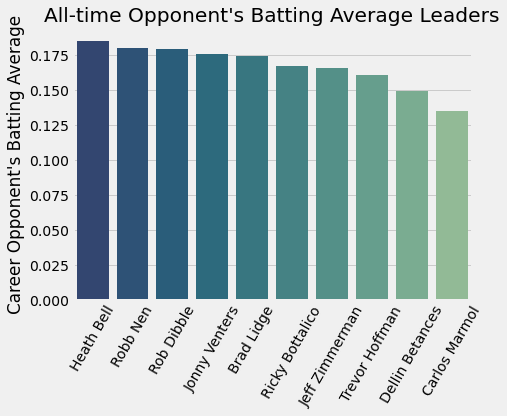

In [137]:
leaders_barplot_sns(baopp_leaders, "BAOpp", stat_label="Opponent's Batting Average")

In [145]:
bp = px.bar(baopp_leaders, 
            x="fullName", 
            y="BAOpp", 
            title=f"Lowest average Opponent Batting Average",
            custom_data=["debut", "finalGame", "IPouts"])
bp.update_traces(hovertemplate="<b>%{x}</b>: %{y} (%{customdata[2]:.1f} outs, %{customdata[0]}-%{customdata[1]})")
bp.update_xaxes(title=None)
bp.update_yaxes(title=f"Opponent Batting Average", tickformat=".3f")

______________________________________________